In [2]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt

# load the configuration file
from l5kit.configs import load_config_data
from l5kit.configs.config import load_metadata
# load the dataset from zarr
from l5kit.data import ChunkedDataset, LocalDataManager
# load the Ego/Agent-based dataset
from l5kit.dataset import EgoDataset, AgentDataset, IntersectionDataset
# define the road_network protobuf data structure
from l5kit.data.proto.road_network_pb2 import RoadNetworkNode, RoadNetworkSegment
# Semantic map api
from l5kit.data.map_api import MapAPI
# rasterizer
from l5kit.rasterization import build_rasterizer
# geometry
from l5kit.geometry import transform_points

from typing import List

D:\github\lyft_intersection\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [3]:
# load the configuration file
cfg = load_config_data("../yaml_config/visualisation_config_sample.yaml")
# print(cfg)

# load the dataset from zarr
os.environ["L5KIT_DATA_FOLDER"] = "../" ## Set the environmental variable
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
# print(dataset_path) # scenes\sample.zarr
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

In [4]:
from l5kit.data.proto.road_network_pb2 import GeoFrame, GlobalId, MapElement, MapFragment

dataset_meta_key = cfg["raster_params"]["dataset_meta_key"]
dataset_meta = load_metadata(dm.require(dataset_meta_key))
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
mapAPI = MapAPI(protobuf_map_path="../semantic_map/semantic_map.pb", world_to_ecef=world_to_ecef)

with open("../semantic_map/semantic_map.pb", "rb") as infile:
            mf = MapFragment()
            mf.ParseFromString(infile.read())

mapAPI.bounds_info.keys()

dict_keys(['lanes', 'crosswalks', 'junctions'])

# To identify the IDs of the studied junctions (unsignalized intersections) in the Lyft dataset:

1. Retrieve the intersection's coordinates from Google Maps, for example, (374191440, -1221506200).
2. Iterate through each node in the MapAPI object, checking if it’s sufficiently close to the target coordinates. If so, add it to a collection.
3. For each collected node, iterate through the junction objects to see if the junction includes the node. If it does, record the junction ID.

In [4]:
def get_node_ids(mf, target_lat: float, target_lon: float, radius: float = 3000) -> List[str]:
    # retrieve all the nodes 
    node_elements = []
    node_ids = []
    node_elements_coords = []
    
    for index in range(mf.elements.__len__()):
        if str(mf.elements[index].element).split(" ")[0] == "node":

            node_elements.append(mf.elements[index].element)
            
            node_ids.append(mf.elements[index].id) # add id of node
            
            lat = mf.elements[index].element.node.location.lat_e7
            lon = mf.elements[index].element.node.location.lng_e7
            node_elements_coords.append((lat, lon)) # add coordinate
    
    # target coordinate: 37.419144, -122.150620 
    # try to find the nodes that are close to the target node.
    # target_lat = 374191440
    # target_lon = -1221506200
    # radius = 3000

    # check whether the node is close enough to the studied intersection.
    qualified_node_ids = []
    for idx, (lat, lon) in enumerate(node_elements_coords):
        if lat < target_lat + radius and target_lat - radius < lat and target_lon - radius < lon and lon < target_lon + radius:
            # print(lat, lon)
            # print(node_elements[idx])
            qualified_node_ids.append(str(node_ids[idx]).split('"')[1])

    return qualified_node_ids

In [5]:
qualified_node_ids = get_node_ids(mf, target_lat=374_191_440, target_lon=-1221506200)
qualified_node_ids

['VJK2', 'RMgS']

In [6]:
def get_junction_id(mf, node_id) -> str:
    """ Get the Junction ID of the studied intersection. """
    ids = list()
    
    for index in range(mf.elements.__len__()):
        map_element_string = str(mf.elements[index].element)
        if str(map_element_string).split(" ")[0] == "junction":
            if node_id in map_element_string:
                ids.append(str(mf.elements[index]).split('"')[1])

    return ids

get_junction_id(mf, qualified_node_ids[0]), get_junction_id(mf, qualified_node_ids[1])

(['sGK1'], [])

In [7]:
qualified_node_ids = get_node_ids(mf, target_lat=374_241_630, target_lon=-1221466390, radius=1000)
qualified_node_ids

['/bBZ']

In [8]:
get_junction_id(mf, qualified_node_ids[0]) # , get_junction_id(mf, qualified_node_ids[1]) # , get_junction_id(mf, qualified_node_ids[2])

['WTgZ']

In [5]:
cfg["raster_params"]["map_type"] = "intersection" # "py_satellite" # "py_semantic"   
intersection_rast = build_rasterizer(cfg, dm)
intersection_dataset = IntersectionDataset(cfg, zarr_dataset, intersection_rast)

In [10]:
from tqdm import tqdm

frames_including_intersection = []
scenes_including_intersection = []

for idx, frame in tqdm(enumerate(intersection_dataset), 
                       total=len(intersection_dataset), 
                       unit="frame",
                       desc=f"Identify the intersection of interest inside {cfg['val_data_loader']['key']}:"):
    if frame["is_intersection_included"]:
        # save the frame_id
        frames_including_intersection.append(idx)
        # FIXME: save the scene_id
        scenes_including_intersection.append(frame["scene_index"])

Identify the intersection of interest inside scenes-sample/sample.zarr:: 100%|█| 24838/24838 [01:41<00:00, 243.57frame/


In [11]:
print(f"#scenes including the intersection:\n{set(scenes_including_intersection)}")

#scenes including the intersection:
{9, 10, 11, 12, 13, 14, 15, 38, 39, 40, 59, 60, 61, 73, 74, 94, 95, 96, 97}


In [23]:
from ..l5kit_conflict. import *

scene_ego_trajectory = get_scene_ego_trajectory(dataset, scene_index=9)
rotate_scene_ego_trajectory = transform_scene_ego_trajectory(scene_ego_trajectory, rotate_matrix)
rotate_scene_ego_trajectory.shape

NameError: name 'get_scene_ego_trajectory' is not defined

In [38]:
dataset.get_scene_indices(11)

array([2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847,
       2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858,
       2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869,
       2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880,
       2881, 2882, 2883, 2884, 2885, 2886, 2887, 28

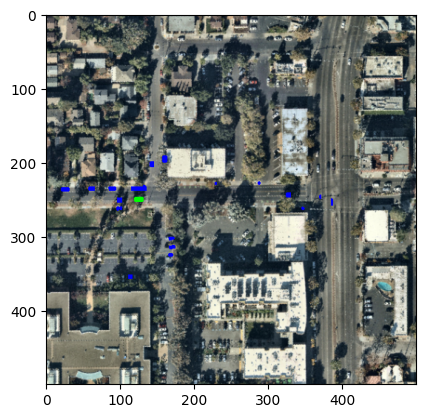

In [39]:
frameIndex = 2737+10
cfg["raster_params"]["map_type"] = "py_satellite" # "intersection" # "py_semantic"   
rast = build_rasterizer(cfg, dm)
dataset = IntersectionDataset(cfg, zarr_dataset, rast)
data = dataset[frameIndex]

im = data["image"].transpose(1, 2, 0) # (224, 224, 5)
im = dataset.rasterizer.to_rgb(im) # (224, 224, 3)
target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
# draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=data["target_yaws"])

plt.imshow(im)
plt.show()

In [32]:
data["centroid"]

array([ 427.06573486, -966.11547852])

In [48]:
trajectory = np.zeros((1,2))
frame_list = intersection_dataset.get_scene_indices(scene_idx=11).tolist() # + intersection_dataset.get_scene_indices(scene_idx=).tolist()
for frame_index in frame_list:
    centroid = intersection_dataset[frame_index]["centroid"].reshape((1,2))
    trajectory = np.append(arr=trajectory, values=centroid, axis=0)

trajectory = trajectory[1:,:]
# plt.plot(trajectory[:,0], trajectory[:,1]) 

(-950.0, -800.0)

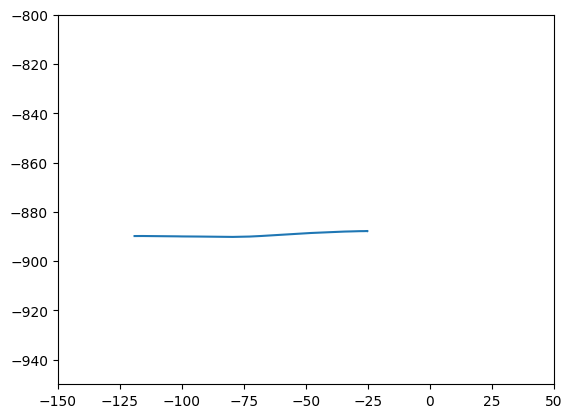

In [49]:
theta = 56.5
rotation_matrix = np.array([
    [np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))], 
    [-1*np.sin(np.deg2rad(theta)), np.cos(np.deg2rad(theta))]
])
rotation_matrix

transformed_trajectory = np.matmul(rotation_matrix, trajectory.T)
plt.plot(transformed_trajectory[0,:], transformed_trajectory[1,:]) 
plt.xlim([-150, 50])
plt.ylim([-950, -800])